## Part 2: Creating PyTorch dataset wrapper

In [1]:
import os, os.path as osp
import re
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import transforms as T
from torch import utils
import pydicom
import cv2
import PIL
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa


#data_dir = 'siim-covid19-detection'
data_dir = '../data'
#data_dir = '/data/siim-covid19-detection'

### Step 1: investigate data augmentations

First we investigate how to apply augmentations to images (resizing, rotations, noise etc) while also keeping the object bounding boxes relative.

In [2]:
class SiimCV19Dataset(utils.data.Dataset):
    def __init__(self, data_dir, transforms=None, test=False, granularity='image'):
        
        self.mode = 'test' if test else 'train'
        # find every image in directory
        file_dir = osp.join(data_dir, f'{self.mode}/**/*.dcm')        
        self.files = glob.glob(file_dir, recursive=True)
        self.files.sort()
        
        # need to create a map that points each study/img id
        # to file path
        self.file_map = dict()
        for idx, file in enumerate(self.files):
            self.file_map[osp.split(file)[1].split('.')[0]] = file 
        
        assert granularity == 'image' or granularity == 'study'        
        # load labels file
        if self.mode == 'train':
            self.labels = pd.read_csv(osp.join(data_dir, f'train_{granularity}_level.csv'))
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            label = self.labels.iloc[idx].label.split(' ')
            # load bounding boxes
            boxes = []
            for i in range(0, len(label), 6):
                # for now we ignore the opacity label
                boxes.append(label[i+2:i+6])
            y = boxes
            # get id of image to read
            im_id = self.labels.iloc[idx].id.split('_')[0]
            im_file = self.file_map[im_id]
            
        elif self.mode == 'test':
            im_file = self.files[idx]
            y = None
        
        X = self._read_dcm(im_file)
        
        #TODO update with code from:
        # https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
        
        # convert 16-bit greyscale to 8-bit rgb
        img = cv2.cvtColor(X,cv2.COLOR_GRAY2RGB)
        img -= img.min()
        img = img / img.max()
        img *= 255
        img = img.astype(np.uint8)
        
        # see https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/B02%20-%20Augment%20Bounding%20Boxes.ipynb   
        bbs = BoundingBoxesOnImage(
            [BoundingBox(*box) for box in boxes],
            shape = img.shape
        )
        
        # random seed for repeatability
        ia.seed(10)
        seq = iaa.Sequential([
            iaa.GammaContrast(1.5),
            #iaa.Affine(translate_percent={"x": 0.1}, scale=0.8),
            iaa.PadToAspectRatio(1.0), 
            iaa.Resize({'height':512, 'width':512})
        ])
        
        image_aug, bbs_aug = seq(image=img, bounding_boxes=bbs)
        
        
        mean, std = img.mean(), img.std()
        
        # change to pytorch usable format
        # transform = T.Compose([T.ToPILImage(), T.ToTensor(), T.Normalize([mean]*3, [std]*3)])
        # transform = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
        
        # X = transform(img)
        # return X, y
        return (img, image_aug), (bbs, bbs_aug)
    
    def __len__(self):
        return len(self.files) if self.mode == 'test' else len(self.labels)
    
    def _read_dcm(self, file):
        ds = pydicom.dcmread(file)
        ds.PhotometricInterpretation = 'YBR_FULL'
        img = ds.pixel_array
        return img

In [3]:
# construct dataset object for training images

data_args = {'data_dir': data_dir, 'test': False, 'granularity':'image'}
img_dataset = SiimCV19Dataset(**data_args)
len(img_dataset)

6334

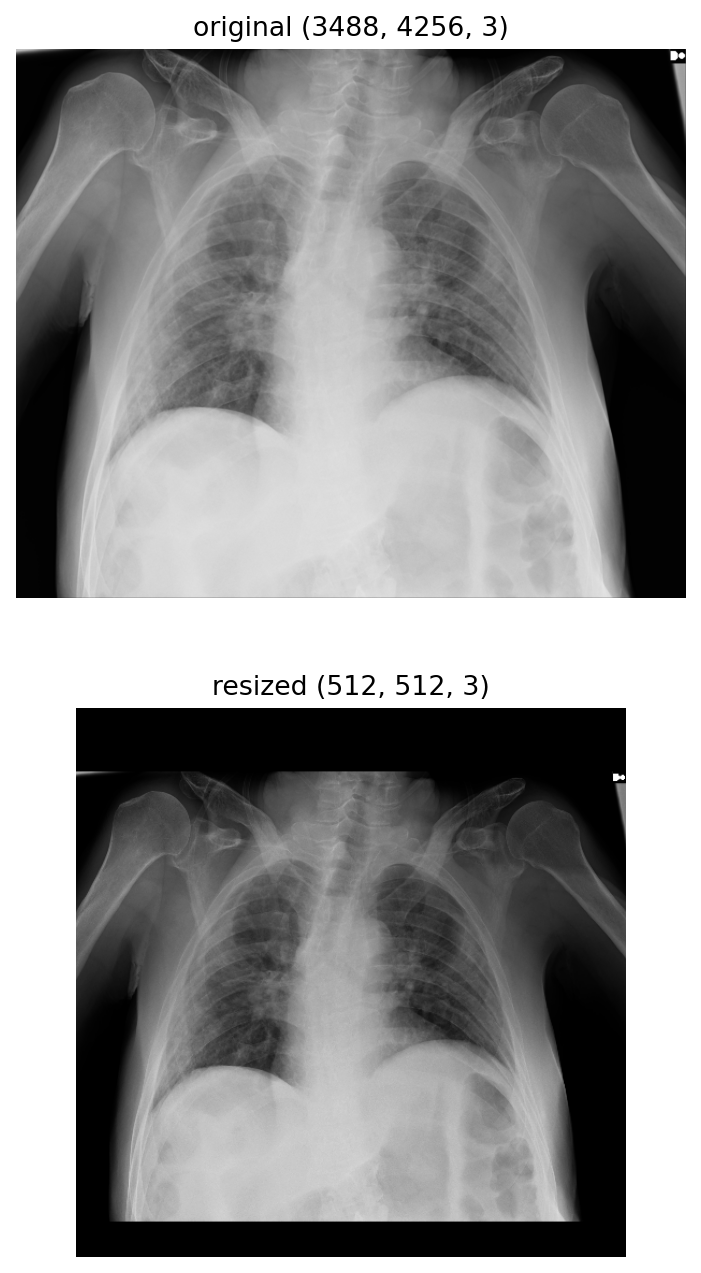

(3488, 4256, 3)

In [4]:
(img, img_aug), (bbs, bbs_aug) = img_dataset[0]

fig, axs = plt.subplots(2,1, figsize=(10,10))
axs[0].imshow(img)
axs[0].set_title(f'original {img.shape}')
axs[1].imshow(img_aug)
axs[1].set_title(f'resized {img_aug.shape}')

[ax.axis('off') for ax in axs]

fig.set_dpi(160)

plt.show()
img.shape

## Step 2: data collation

Now need to create the functionality to allow datapoints to be effectively batched

In [5]:
from torch import utils
import os.path as osp
import re
from torchvision import transforms as T
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa

class SiimCV19Dataset(utils.data.Dataset):
    def __init__(self, data_dir, transforms=None, test=False, granularity='image'):
        
        self.mode = 'test' if test else 'train'
        # find every image in directory
        file_dir = osp.join(data_dir, f'{self.mode}/**/*.dcm')        
        self.files = glob.glob(file_dir, recursive=True)
        self.files.sort()
        
        # need to create a map that points each study/img id
        # to file path
        self.file_map = dict()
        for idx, file in enumerate(self.files):
            self.file_map[osp.split(file)[1].split('.')[0]] = file 
        
        assert granularity == 'image' or granularity == 'study'        
        # load labels file
        if self.mode == 'train':
            self.labels = pd.read_csv(osp.join(data_dir, f'train_{granularity}_level.csv'))
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            label = self.labels.iloc[idx].label.split(' ')
            # load bounding boxes
            boxes = []
            for i in range(0, len(label), 6):
                # for now we ignore the opacity label
                boxes.append(label[i+2:i+6])
            y = boxes
            # get id of image to read
            im_id = self.labels.iloc[idx].id.split('_')[0]
            im_file = self.file_map[im_id]
            
        elif self.mode == 'test':
            im_file = self.files[idx]
            y = None
        
        X = self._read_dcm(im_file)
        
        #TODO update with code from:
        # https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
        
        # convert 16-bit greyscale to 8-bit rgb
        img = cv2.cvtColor(X,cv2.COLOR_GRAY2RGB)
        img -= img.min()
        img = img / img.max()
        img *= 255
        img = img.astype(np.uint8)
        
        # see https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/B02%20-%20Augment%20Bounding%20Boxes.ipynb   
        bbs = BoundingBoxesOnImage(
            [BoundingBox(*box) for box in boxes],
            shape = img.shape
        )
        
        # random seed for repeatability
        ia.seed(10)
        seq = iaa.Sequential([
            iaa.GammaContrast(1.5),
            #iaa.Affine(translate_percent={"x": 0.1}, scale=0.8),
            iaa.PadToAspectRatio(1.0), 
            iaa.Resize({'height':512, 'width':512})
        ])
        
        image_aug, bbs_aug = seq(image=img, bounding_boxes=bbs)
        
        
        mean, std = img_aug.mean(), img_aug.std()
        
        # change to pytorch usable format
        # transform = T.Compose([T.ToPILImage(), T.ToTensor(), T.Normalize([mean]*3, [std]*3)])
        transform = T.Compose([T.ToPILImage(), T.ToTensor(), T.Normalize([mean]*3, [std]*3)])
        
        X = transform(img_aug)
        boxes = torch.stack([torch.tensor(box.coords.flatten()) for box in bbs.bounding_boxes])
        return X, boxes
    
    def __len__(self):
        return len(self.files) if self.mode == 'test' else len(self.labels)
    
    def _read_dcm(self, file):
        ds = pydicom.dcmread(file)
        ds.PhotometricInterpretation = 'YBR_FULL'
        img = ds.pixel_array
        return img

In [6]:
data_args = {'data_dir': data_dir, 'test': False, 'granularity':'image'}
img_dataset = SiimCV19Dataset(**data_args)
len(img_dataset)

6334

In [7]:
def collate_fn(batch):
    X, y = [], []
    for item in batch:
        X.append(item[0])
        y.append(item[1])    
    return (torch.stack(X), y)

batch_size = 256
# enable multiprocessing for unix like os only
# as it is horribly broken on windows
num_workers = -1 if os.name == 'posix' else 0

loader_args = {'pin_memory':True, 
               'num_workers':num_workers, 
               'shuffle':False, 
               'batch_size':batch_size, 
               'collate_fn':collate_fn}
loader = torch.utils.data.DataLoader(img_dataset, **loader_args)

In [8]:
batch = next(iter(loader))
X, y = batch
X.shape, len(y)

C:\Users\chris\anaconda3\envs\ai\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


(torch.Size([256, 3, 512, 512]), 256)

In [9]:
print(f'using batch size {batch_size} takes {(X.element_size() * X.nelement()) / 2**30} GiB of memory for image data and {sum([item.element_size()*item.nelement() for item in y]) / 2**10} KiB for target data')

using batch size 256 takes 0.75 GiB of memory for image data and 6.328125 KiB for target data
